# Обучение на реальных данных

С какими проблемами чаще всего сталкиваются люди, работающие с машинным обучением, в реальной жизни?
- нехватка данных
- недостаток размеченных данных
- не качественная разметка
- низкое качество изображений
- не сбалансированность датасета
- переобучение
- **какие еще?**


## Как решить проблему малого количества данных?

<!-- ResNet (популярная архитектура для классификации изображений), заняла 1-е место в классификационном конкурсе ILSVRC 2015 с улучшением примерно на 50% по сравнению с предыдущим уровнем развития техники. ResNet не только имела очень сложную и глубокую архитектуру, но и была обучена на 1,2 млн изображений.

Как в отрасли, так и в академических кругах хорошо известно, что при достаточно большом количестве данных, очень разные алгоритмы DL работают практически одинаково. Следует отметить, что большие данные должны содержать значимую информацию, а не просто шум, чтобы модель могла извлекать уроки из них. -->
[Блог-пост о том как решать проблему малого количества данных?](https://towardsdatascience.com/breaking-the-curse-of-small-datasets-in-machine-learning-part-1-36f28b0c044d)

На рисунке показаны основные проблемы, с которыми приходится сталкиваться при работе с небольшими наборами данных, а также возможные подходы и методы их решения.

<img src ="http://edunet.kea.su/repo/src/L11_Transfer_learning/img/L11_33.png" width="700">


### Работа с несбалансированным датасетом

Сначала, давайте рассмотрим методы работы с датасетами в которых классы представлены не равномерно.


Сгенерируем датасет

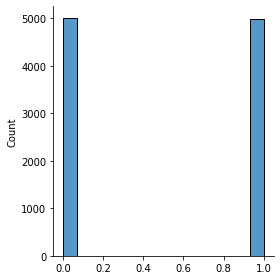

In [2]:
from sklearn.datasets import make_classification
import seaborn as sns

x, y = make_classification(n_samples=10000, n_features=10, n_classes=2)
sns.displot(y, height=4)

И теперь его испортим (изменим соотношение класса `0` и класса `1`)

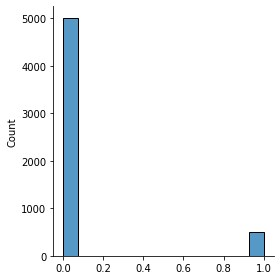

In [3]:
y_new = np.random.choice(y[y == 1], size=np.int(0.1 * len(y[y == 1])))
y_new = np.hstack([y[y == 0], y_new])
x_new = x[y_new]

sns.displot(y_new, height=4)

#### Что можно сделать, что бы как-то улучшить ситуацию используя методы ML:

- **Измените функцию потерь**: для задач классификации мы часто используем кросс-энтропийную потерю и редко используем среднюю абсолютную ошибку или среднеквадратичную ошибку для обучения и оптимизации нашей модели.

- В случае несбалансированных данных, модель учится распознавать доминирующий класс чаще чем все остальные, соответственно, она выучивает статистическое распределение классов и считает что чем чаще она предсказывает этот класс - тем меньше она ошибается. Что бы как-то решить эту проблему - мы можем **добавить веса к потерям**, соответствующим различным классам, чтобы выровнять это смещение данных. Например, если у нас есть два класса в соотношении 4:1, мы можем применить веса в соотношении 1:4 к вычислению функции потерь, чтобы данные были сбалансированы. 

Этот метод помогает нам легко смягчить проблему несбалансированных данных и улучшить обобщение модели для разных классов. Например:

In [5]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight("balanced", np.unique(y_new), y_new)
print(class_weights)

[0.54987008 5.51302605]


Мы также можем указать явные веса классов в соответствии с нашими требованиями.

Дополнительные сведения смотри в документации Scikit-learn.

In [ ]:
# from sklearn.linear_model import LogisticRegression

# # Create decision tree classifer object
# clf = LogisticRegression(random_state=0, class_weight='balanced')

# # Train model
# model = clf.fit(x, y_new)

Еще один способ решение проблемы несбалансированных данных - собственно их балансирование. Это может быть сделано либо за счет увеличения частоты класса меньшинства (_oversampling_), либо за счет уменьшения частоты класса большинства (_undersampling_) с помощью методов случайной или кластерной выборки.

Обычно _oversampling_ предпочтителен, когда общий размер данных небольшой, а _undersampling_ полезен, когда у нас есть большой объем данных. Точно так же случайная или кластерная выборка определяется тем, насколько хорошо распределены данные.


<img src ="http://edunet.kea.su/repo/src/L11_Transfer_learning/img/L11_34.png" width="600">

Вот тут можно прочитать подробнее: [Imbalanced Data : How to handle Imbalanced Classification Problems](https://www.analyticsvidhya.com/blog/2017/03/imbalanced-data-classification/)

`Resampling` может быть легко выполнен с помощью пакета [imbalanced-learn](https://pypi.org/project/imbalanced-learn/), как показано ниже:

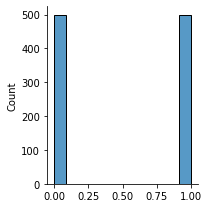

In [6]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(x_new, y_new)
sns.displot(y_res, height=3)

#### Генерация синтетических данных: 

хотя `oversampling` или `undersampling` помогает сбалансировать данные, дублирование данных увеличивает вероятность переобучения.

Другой подход к решению этой проблемы - создание синтетических данных с помощью данных о классе меньшинств.

**Synthetic Minority Over-sampling Technique (SMOTE)** или **Modified- SMOTE** - два таких метода, которые генерируют синтетические данные. Проще говоря, SMOTE берет точки данных класса меньшинства и создает новые точки данных, которые лежат между любыми двумя ближайшими точками данных, соединенными прямой линией.

Для этого алгоритм вычисляет расстояние между двумя точками данных в пространстве признаков, умножает расстояние на случайное число от 0 до 1 и помещает новую точку данных на этом новом расстоянии от одной из точек данных, используемых для определения расстояния.

Обратите внимание, что количество ближайших соседей, учитываемых для генерации данных, также является гиперпараметром и может быть изменено в зависимости от требований.

<img src ="http://edunet.kea.su/repo/src/L11_Transfer_learning/img/L11_35.png" width="700">

M-SMOTE - это модифицированная версия SMOTE, которая также принимает во внимание базовое распределение класса меньшинства.

Алгоритм классифицирует образцы классов меньшинств на 3 отдельные группы - образцы безопасности / безопасности, образцы границ и образцы скрытого шума.

Это делается путем вычисления расстояний между выборками класса меньшинства и выборками обучающих данных.

В отличие от SMOTE, алгоритм случайным образом выбирает точку данных из k ближайших соседей для выборки безопасности, выбирает ближайшего соседа из выборок границ и ничего не делает для устранения скрытого шума.

Вот тут можно прочитать подробнее: [SMOTE explained for noobs - Synthetic Minority Over-sampling TEchnique line by line](https://rikunert.com/SMOTE_explained)

#### Обнаружение аномалий / изменений

В случае сильно несбалансированных наборов данных, таких как мошенничество или машинный сбой, стоит задуматься, могут ли такие примеры рассматриваться как аномалия (выброс) или нет. Если такое событие и впрямь может считаться аномальным, мы можем использовать такие модели, как `OneClassSVM`, методы кластеризации или методы обнаружения гауссовских аномалий.

Эти методы требуют изменения способа мышления: мы будем рассматривать аномалии, как отдельный класс выбросов. Это может помочь нам найти новые способы разделения и классификации.

Обнаружение изменений похоже на обнаружение аномалий, за исключением того, что мы ищем изменение или отличие, а не аномалию. Это могут быть изменения в поведении пользователя, наблюдаемые по шаблонам использования или банковским транзакциям.

Разберем пример обнаружения аномалий с помощью `OneClassSVM` из библиотеки Sk-Learn (там же, можно найти еще множеество различных алгоритмов)

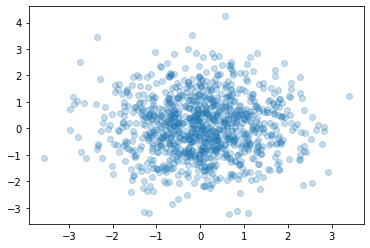

In [7]:
from sklearn.svm import OneClassSVM
from sklearn.datasets import make_blobs
from numpy import quantile, where, random
import matplotlib.pyplot as plt

# Создадим датасет
x, _ = make_blobs(n_samples=1000, centers=1, cluster_std=1.1, center_box=(0, 0))
plt.scatter(x[:, 0], x[:, 1], alpha=0.25)
plt.show()

Настроим наш детектор аномалий

In [8]:
svm = OneClassSVM(kernel="rbf", gamma=0.01, nu=0.03)
print(svm)
svm.fit(x)
pred = svm.predict(x)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.01, kernel='rbf',
            max_iter=-1, nu=0.03, shrinking=True, tol=0.001, verbose=False)


Продемонстрируем аномальные точки предсказанные детектором

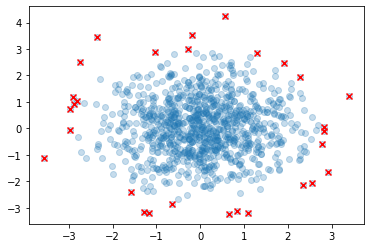

In [10]:
anom_index = where(pred == -1)
values = x[anom_index]

plt.scatter(x[:, 0], x[:, 1], alpha=0.25)
plt.scatter(values[:, 0], values[:, 1], color="r", marker="x")

#### Методы объединения (Ensembling Techniques): 

Помимо того, что бы делать что-то с данными, мы можем попробовать сделать что-то с самой моделью. 
Идея объединения нескольких слабых учеников / разных моделей показала отличные результаты при работе с несбалансированными наборами данных.

`Bagging` и `Boosting` методы также показали отличные результаты при решении различных задач, и их следует изучить вместе с методами, описанными выше, для получения лучших результатов.

Вот тут подробнее: [Imbalanced Data : How to handle Imbalanced Classification Problems](https://www.analyticsvidhya.com/blog/2017/03/imbalanced-data-classification/)

**Вывод:**

Мы рассмотрели несколько наиболее часто используемых методов работы с несбалансированными данными для традиционных алгоритмов машинного обучения.

Один или многие из вышеперечисленных методов могут быть хорошей отправной точкой в ​​зависимости от конкретной бизнес-задачи.

### 8 тактик борьбы с несбалансированными классами в наборе данных машинного обучения

[Блог пост про 8 тактик борьбы с несбалансированными классами в наборе данных машинного обучения](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)

1. **Определите, можете ли вы собрать больше данных?**
2. **Попробуйте изменить метрику оценки модели.**
    Accuracy не является показателем, который следует использовать при работе с несбалансированным набором данных. [Есть метрики, которые были разработаны для работы с несбалансированными классами.](https://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/#:~:text=Classification%20Accuracy%20is%20Not%20Enough%3A%20More%20Performance%20Measures%20You%20Can%20Use,-By%20Jason%20Brownlee&text=When%20you%20build%20a%20model,This%20is%20the%20classification%20accuracy)

3. **Применить `Resampling`** (см. выше)
4. **Попробовать создать синтетические образцы данных**
5. **Не следует использовать свой любимый алгоритм для каждой задачи.**
    Необходимо проверять различные типы алгоритмов для решения конкретной проблемы. Например, `Random Forest` часто хорошо работает с несбалансированными наборами данных.
6. **Попробуйте модели с санкциями**
    Штрафная классификация накладывает дополнительные штрафы на модель за ошибки классификации в классе меньшинства во время обучения. Эти штрафы могут склонить модель к уделению большего внимания классу меньшинства.
7. **Попробуйте другую точку зрения**
    Есть области исследований, посвященные несбалансированным наборам данных. Двe, которые вы могли бы рассмотреть, - это [обнаружение аномалий](https://en.wikipedia.org/wiki/Anomaly_detection) и [обнаружение изменений](https://en.wikipedia.org/wiki/Change_detection).
8. **[Попробуйте проявить творческий подход](https://www.quora.com/In-classification-how-do-you-handle-an-unbalanced-training-set)**.
    По-настоящему залезьте внутрь своей проблемы и подумайте, как разбить ее на более мелкие проблемы, которые легче решить.

**Перейдем к особенностям работы с несбалансированными классами в моделях нейронных сетей**

## Аугментация

Сам термин пришел из музыки:

**Аугмента́ция** (позднелат. augmentatio — увеличение, расширение) — [техника ритмической композиции в старинной музыке](https://ru.wikipedia.org/wiki/Аугментация).

Сейчас такая работа с данными активно применяется в работе с изображениями, но ее можно использоваться и для сигналов, и, иногда, для табличных данных.

Модели глубокого обучения обычно требуют большого количества данных для обучения. В целом, чем больше данных, тем лучше для обучения модели.

Но получение огромных объемов данных сопряжено со своими проблемами.

Вместо того, чтобы тратить дни на сбор данных вручную, мы можем использовать методы увеличения их числа путем генерации новых из уже имеющихся.



<img src ="http://edunet.kea.su/repo/src/L11_Transfer_learning/img/L11_12.png" width="700">

### Примеры аугументации в [TORCHVISION.TRANSFORMS](https://pytorch.org/vision/stable/transforms.html)

<img src ="http://edunet.kea.su/repo/src/L11_Transfer_learning/img/L11_13.png" width="700">

In [93]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.utils
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import time
from torchsummary import summary
from torch.autograd import Variable

import numpy as np
import random
import matplotlib.pyplot as plt
import os

from PIL import Image
import PIL.ImageOps

from IPython.display import clear_output
from zipfile import ZipFile

import warnings

warnings.filterwarnings("ignore")

#Фиксируем random_seed
import torch
import random
import numpy as np
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

#Выставлям device для расчетов
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
os.chdir('/content')
# скачаем необходимые файлы
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=11LBkRRlagM4ijHsXkytgSae4NJtW98sB' -O data.zip
with ZipFile('data.zip', 'r') as folder: # Create a ZipFile Object and load sample.zip in it
    folder.extractall() # Extract all the contents of zip file in current directory
clear_output()

In [5]:
os.chdir("/content/for_transforms.Compose")
img_list = os.listdir()
img_list

['bicornis2.jpg',
 'horse1.jpg',
 'horse2.jpg',
 'horse5.jpg',
 'bicornis5.jpg',
 'bicornis1.jpg',
 'horse4.jpg',
 'bicornis3.jpg']

In [6]:
class AugmentationDataset(Dataset):
    def __init__(self, image_list, transforms=None):
        self.image_list = image_list
        self.transforms = transforms

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, i):
        img = plt.imread(self.image_list[i])
        img = Image.fromarray(img).convert("RGB")
        img = np.array(img).astype(np.uint8)

        if self.transforms is not None:
            img = self.transforms(img)
        return torch.tensor(img, dtype=torch.float)


def show_img(img):
    plt.figure(figsize=(40, 38))
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Существует несколько методов аугментации изображений, и мы обсудим некоторые из наиболее распространенных и широко используемых.

Вы можете попробовать другие методы в соответствии с вашими требованиями.

### Image Rotation

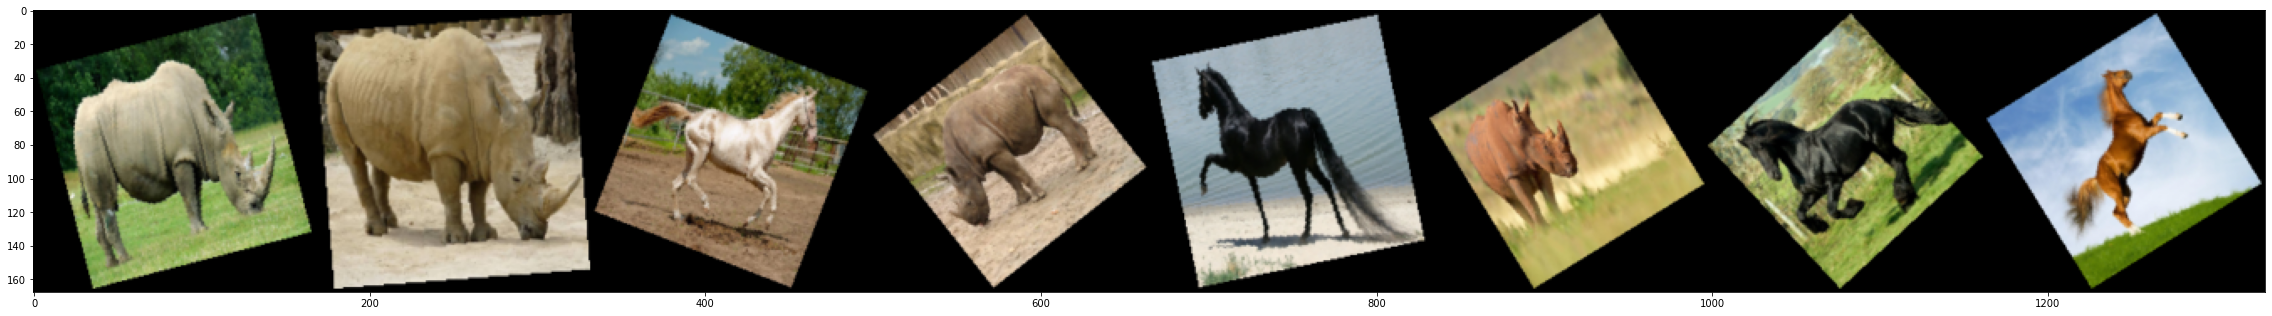

In [7]:
transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((164, 164)),
        transforms.RandomRotation(50, expand=True),
        transforms.Resize((164, 164)),
        transforms.ToTensor(),
    ]
)

Augmentation_dataloader = DataLoader(
    AugmentationDataset(img_list, transform), batch_size=8, shuffle=True
)

data = iter(Augmentation_dataloader)
show_img(torchvision.utils.make_grid(data.next()))

### Random Cropping

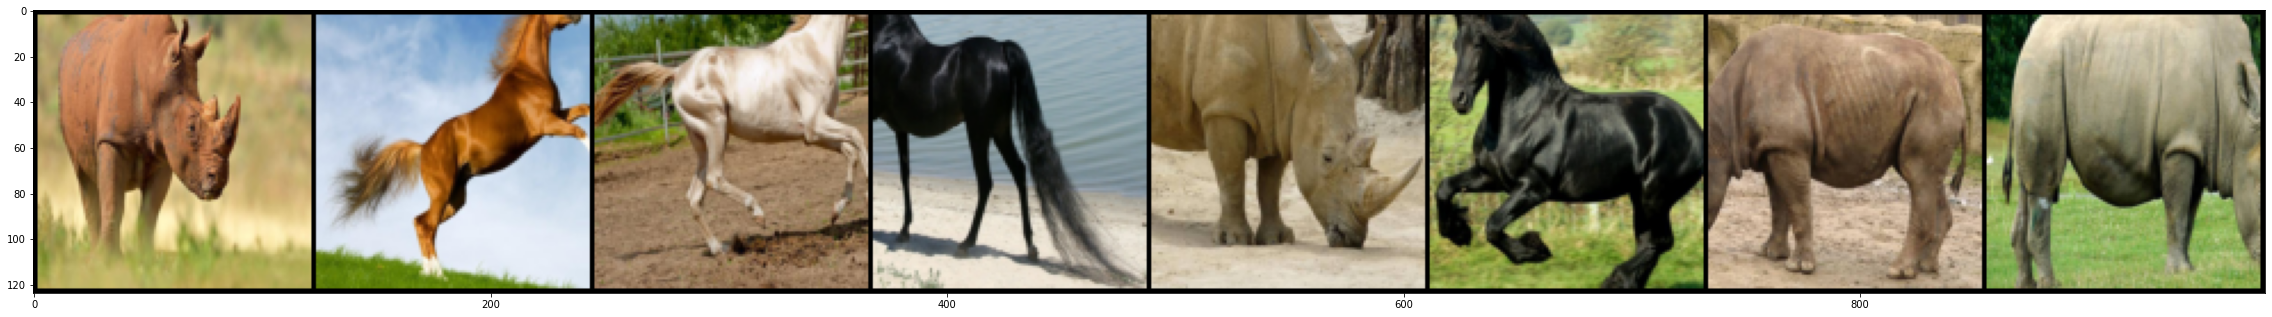

In [8]:
transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((164, 164)),
        transforms.RandomCrop((120, 120)),
        transforms.ToTensor(),
    ]
)

Augmentation_dataloader = DataLoader(
    AugmentationDataset(img_list, transform), batch_size=8, shuffle=True
)

data = iter(Augmentation_dataloader)
show_img(torchvision.utils.make_grid(data.next()))

### Random Perspective

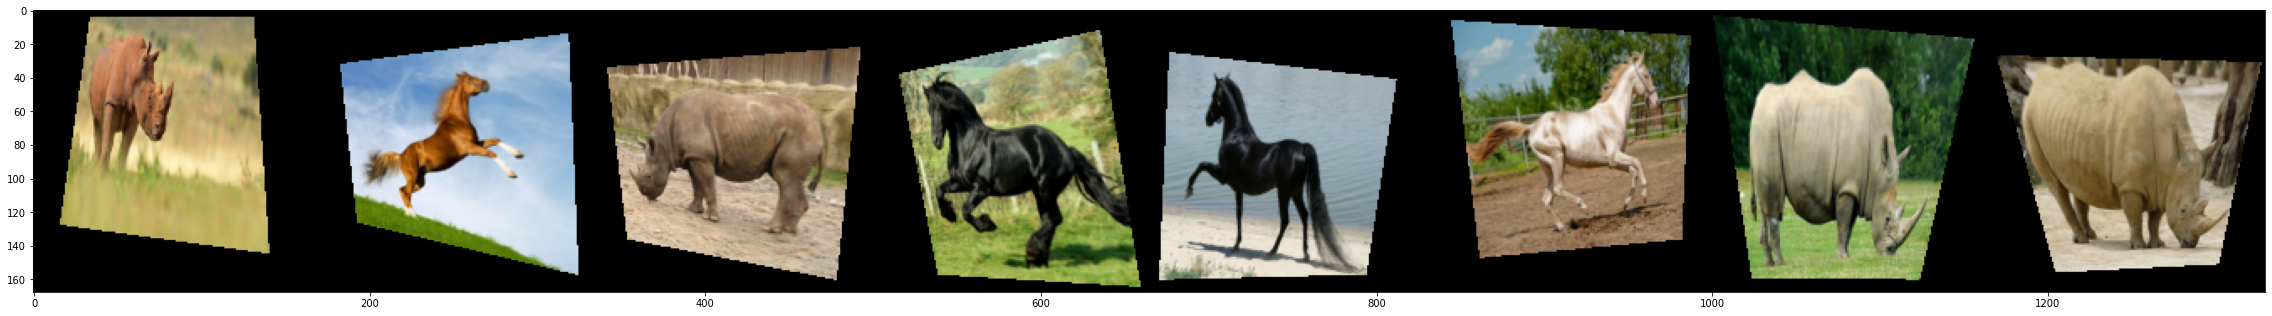

In [9]:
transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((164, 164)),
        transforms.RandomPerspective(distortion_scale=0.5, p=1.0),
        transforms.ToTensor(),
    ]
)

Augmentation_dataloader = DataLoader(
    AugmentationDataset(img_list, transform), batch_size=8, shuffle=True
)

data = iter(Augmentation_dataloader)
show_img(torchvision.utils.make_grid(data.next()))

### Gaussian Blur

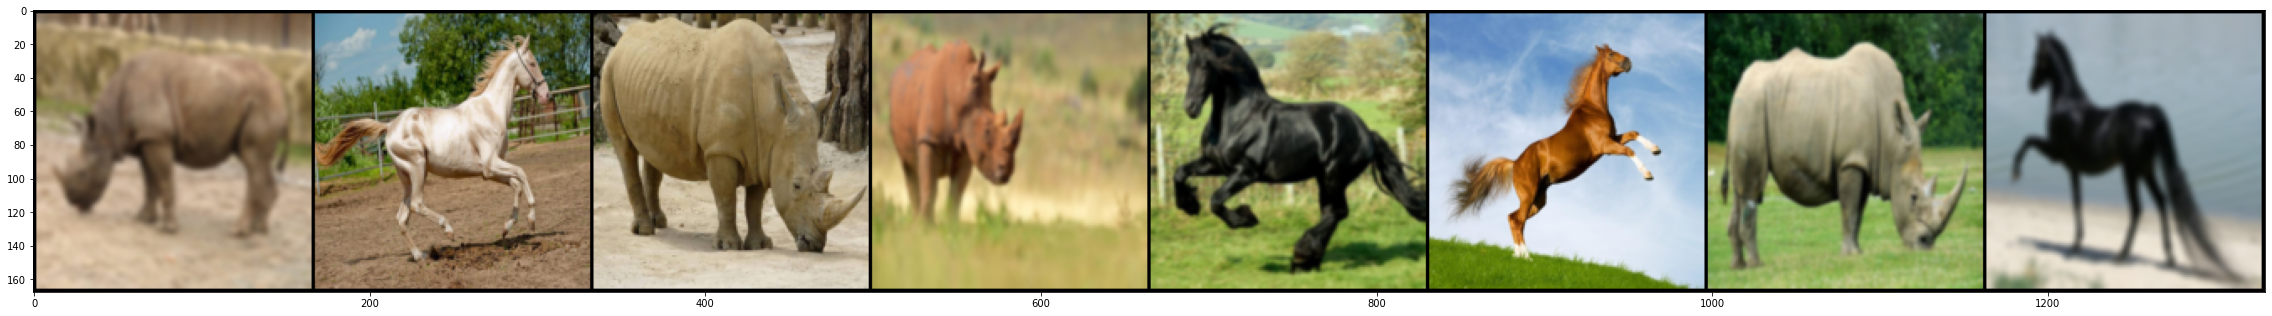

In [10]:
transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((164, 164)),
        transforms.GaussianBlur(7, sigma=(0.1, 2.0)),
        transforms.ToTensor(),
    ]
)

Augmentation_dataloader = DataLoader(
    AugmentationDataset(img_list, transform), batch_size=8, shuffle=True
)

data = iter(Augmentation_dataloader)
show_img(torchvision.utils.make_grid(data.next()))

### Random Erasing

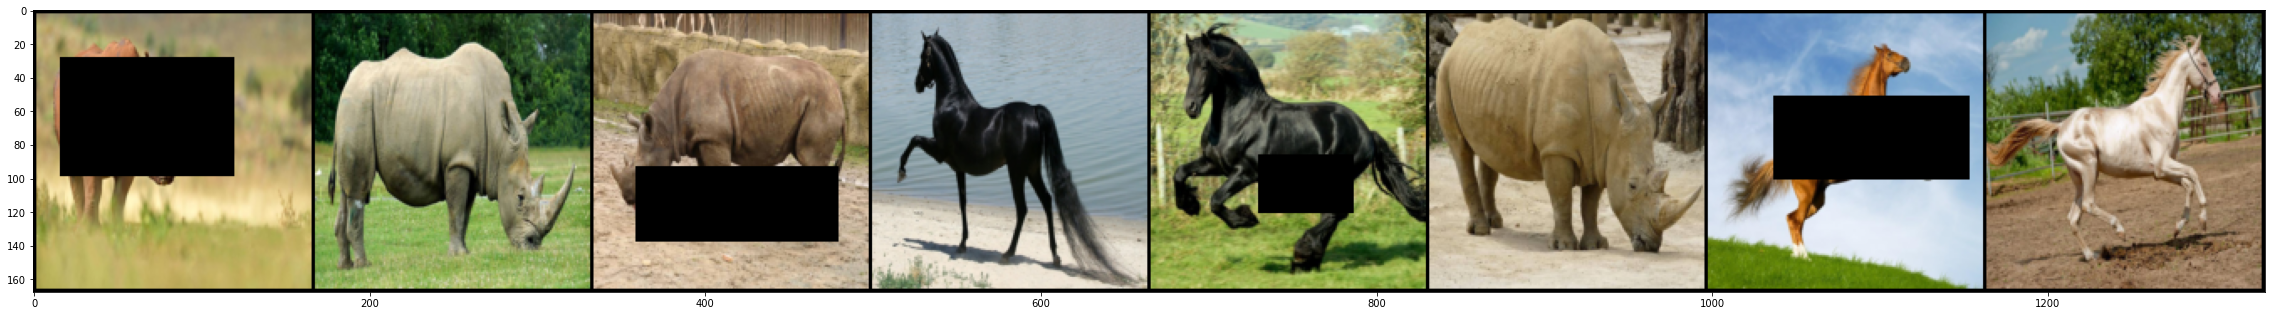

In [11]:
transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((164, 164)),
        transforms.ToTensor(),
        transforms.RandomErasing(),
    ]
)

Augmentation_dataloader = DataLoader(
    AugmentationDataset(img_list, transform), batch_size=8, shuffle=True
)

data = iter(Augmentation_dataloader)
show_img(torchvision.utils.make_grid(data.next()))

Существует и более сложные способы аугментации:

- **Mixup**

<img src ="http://edunet.kea.su/repo/src/L11_Transfer_learning/img/L11_16.png" width="700">

- **Аугументация при помощи синтеза данных**

<img src ="http://edunet.kea.su/repo/src/L11_Transfer_learning/img/L11_17.png" width="700">

В домашнем задании Вам предстоит провести эксперимент: обучить нейронную сеть на датасете без аугментации, и после нее.



Кроме методов, реализованных в Pytorch, существуют и специализированные библиотеки для аугментации изображений. 

Например:
- [lbumentations](https://albumentations.ai)
- [imgaug](https://imgaug.readthedocs.io/en/latest/index.html)

**При выборе методов аугментации имеет смысл использовать те, которые будут в реальной жизни. Например, нет смысла делать перевод изображения в черно-белое, если предполагается, что весь входящий поток будет цветным, или отражать человека вверх-ногами, если мы не предполагаем его таким распознавать.**

## Transfer Learning
----
как быстро обучить нейросеть на своих данных, когда их мало


Для таких типовых задач, как классификация изображений, можно воспользоваться готовой архитектурой (AlexNet, VGG, Inception, ResNet и т.д.) и обучить нейросеть на своих данных. Реализации таких сетей с помощью различных фреймворков уже существуют, так что на данном этапе можно использовать одну из них как черный ящик, не вникая глубоко в принцип её работы.

Однако, глубокие нейронные сети требовательны к большим объемам данных для сходимости обучения. И зачастую, в нашей частной задаче недостаточно данных для того, чтобы хорошо натренировать все слои нейросети. `Transfer Learning` решает эту проблему. Зачем обучать сеть заново, если можно использовать уже обученную на миллионе изображений и дообучить на свой датасет?

В PyTorch есть много предобученных сетей: [`torchvision.models`](https://pytorch.org/vision/stable/models.html)

Для этого,  нужно отключить какие-то промежуточные слои. Тогда можно использовать то, что называется `Fine turning` - не нужно обучать всю модель, а достаточно только ее новую часть.

Нейронные сети, которые используются для классификации, как правило, содержат N выходных нейронов в последнем слое, где N — это количество классов. Такой выходной вектор трактуется как набор вероятностей принадлежности к классу. 

В реальных задачах распознавания изображений, количество классов может отличаться от того, которое было в исходном датасете. В таком случае нам придётся полностью выкинуть этот последний слой и поставить новый, с нужным количеством выходных нейронов

<img src ="http://edunet.kea.su/repo/src/L11_Transfer_learning/img/L11_21.png" width="700">

Зачастую в конце классификационных сетей используется полносвязный слой. Так как мы заменили этот слой, использовать предобученные веса для него уже не получится. Придется тренировать его с нуля, инициализировав его веса случайными значениями. Веса для всех остальных слоев мы загружаем из предобученной модели.

Существуют различные стратегии дообучения модели. Мы воспользуемся следующей: будем тренировать всю сеть из конца в конец (end-to-end), а предобученные веса не будем фиксировать, чтобы дать им немного скорректироваться и подстроиться под наши данные. Такой процесс называется тонкой настройкой (fine-tuning).

### Структурные компоненты

Для решения задачи нам понадобятся следующие компоненты:

1. Описание модели нейросети
2. Пайплайн обучения
3. Инференс пайплайн
4. Предобученные веса для этой модели
5. Данные для обучения и валидации


<img src ="http://edunet.kea.su/repo/src/L11_Transfer_learning/img/L11_1.png" width="650">

### Обучение модели

Код обучения модели состоит из следующих шагов:

1. Построение train/validation пайплайнов данных
2. Построение train/validation графов (сетей)
3. Надстраивание классификационной функция потерь (cross entropy loss) поверх train графа
4. Код, необходимый для вычисления точности предсказания на валидационной выборке во время обучения
5. Логика загрузки предобученных весов из снэпшота
6. Создание различных структур для обучения
7. Непосредственно сам цикл обучения (итерационная оптимизация)

Последний слой графа конструируется с нужным нам количеством нейронов и исключается из списка параметров, загружаемых из предобученного снэпшота.


### Модель

Давайте рассмотрим пример практической реализации такого подхода ([код переработан из этой статьи](https://learnopencv.com/image-classification-using-transfer-learning-in-pytorch/))

Обратите внимание на аугментацию изображений нашего датасета!


In [1]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.utils
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import time
from torchsummary import summary
from torch.autograd import Variable

import numpy as np
import random
import matplotlib.pyplot as plt
import os

from PIL import Image
import PIL.ImageOps

from IPython.display import clear_output
from zipfile import ZipFile

import warnings

warnings.filterwarnings("ignore")

#Фиксируем random_seed
import torch
import random
import numpy as np
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

#Выставлям device для расчетов
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# Applying Transforms to the Data
image_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize(size=128),
            transforms.RandomRotation(degrees=15),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    "valid": transforms.Compose(
        [
            transforms.Resize(size=128),
            transforms.ToTensor(),
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.Resize(size=128),
            transforms.ToTensor(),
        ]
    ),
}

In [3]:
os.chdir('/content')
!git clone https://github.com/YoussefAch/RPS-classification-using-PyTorch.git
!tar -xvz -f /content/RPS-classification-using-PyTorch/RPS.tar.gz 
clear_output()

In [4]:
import shutil
import glob
import random
from sklearn.model_selection import train_test_split

src = "/content/RPS/"

all_data = [filename for filename in glob.iglob(src + "**/*.jpg", recursive=True)]
training_path, testing_path = train_test_split(all_data, test_size=0.1, random_state=42)

train_path = src + "train/"
os.makedirs(train_path, exist_ok=True)
os.makedirs(train_path + "Paper/", exist_ok=True)
os.makedirs(train_path + "Scissors/", exist_ok=True)
os.makedirs(train_path + "Rock/", exist_ok=True)
for file_name in training_path:
    full_file_name = os.path.join(src, file_name)
    if os.path.isfile(full_file_name):
        shutil.copy(full_file_name, train_path + file_name.split("/")[3] + "/")

test_path = src + "test/"
os.makedirs(test_path, exist_ok=True)
os.makedirs(test_path + "Paper/", exist_ok=True)
os.makedirs(test_path + "Scissors/", exist_ok=True)
os.makedirs(test_path + "Rock/", exist_ok=True)
for file_name in testing_path:
    full_file_name = os.path.join(src, file_name)
    if os.path.isfile(full_file_name):
        shutil.copy(full_file_name, test_path + file_name.split("/")[3] + "/")

In [5]:
len(training_path), len(testing_path)

(180, 20)

In [6]:
# Batch size
bs = 8

# Number of classes
num_classes = 3

# Load Data from folders
data = {
    "train": datasets.ImageFolder(root=train_path, transform=image_transforms["train"]),
    "valid": datasets.ImageFolder(root=test_path, transform=image_transforms["valid"]),
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data["train"].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data["train"])
valid_data_size = len(data["valid"])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data["train"], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data["valid"], batch_size=bs, shuffle=True)

{0: 'Paper', 1: 'Rock', 2: 'Scissors'}


In [7]:
train_data_size, valid_data_size

(180, 20)

У нас не так уж и много изображений!! Обычная нейронка справиться не должна.

Загрузим предобученную Alexnet с сохранением весов

In [8]:
alexnet = models.alexnet(pretrained=True)
alexnet

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Поскольку большинство параметров в нашей предварительно обученной модели уже обучены, мы сбрасываем значение поля requires_grad в значение false.

**Заморозка параметров**: отключение переменных предобученной модели для последующих изменений. "Замораживая" переменные предобученной модели мы гарантируем, что обучаться будет только последний классификационный слой, а значения предобученной модели останутся прежними.

In [9]:
# Freeze model parameters
for param in alexnet.parameters():
    param.requires_grad = False

Затем мы заменяем последний слой модели Alexnet одним последовательным слоем с 4096 нейронами и который имеет `num_classes` выходов, соответствующих числу классов в нашем подмножестве.

То есть мы "сказали" нашей модели распознавать не 1000, а только 3 класса.

In [10]:
# Change the final layer of AlexNet Model for Transfer Learning
alexnet.classifier[6] = nn.Linear(4096, num_classes)
alexnet.classifier.add_module("7", nn.LogSoftmax(dim=1))
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Затем мы определяем функцию потерь и оптимизатор, который будет использоваться для обучения.

Мы используем функцию Negative Loss Likelihood, поскольку она полезна для классификации нескольких классов.

И оптимизатор Adam - один из самых популярных оптимизаторов, потому что он может адаптировать скорость обучения для каждого параметра индивидуально.

In [11]:
# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=5e-5)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 5e-05
    weight_decay: 0
)

Для тренировки и валидации нашей можели напишем отдельную функцию, которую итмеет смысл изучить подробнее.

In [12]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    """
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    """

    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch + 1, epochs))

        # Set to training mode
        model.train()

        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()  # Clean existing gradients
            outputs = model(
                inputs
            )  # Forward pass - compute outputs on input data using the model
            loss = loss_criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagate the gradients
            optimizer.step()  # Update the parameters

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

        # Validation - No gradient tracking needed
        with torch.no_grad():

            model.eval()  # Set to evaluation mode

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(
                    inputs
                )  # Forward pass - compute outputs on input data using the model
                loss = loss_criterion(outputs, labels)  # Compute loss
                valid_loss += loss.item() * inputs.size(
                    0
                )  # Compute the total loss for the batch and add it to valid_loss

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

        # Find average training loss and training accuracy
        avg_train_loss = train_loss / train_data_size
        avg_train_acc = train_acc / train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss / valid_data_size
        avg_valid_acc = valid_acc / valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])

        epoch_end = time.time()

        print(
            "Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(
                epoch + 1,
                avg_train_loss,
                avg_train_acc * 100,
                avg_valid_loss,
                avg_valid_acc * 100,
                epoch_end - epoch_start,
            )
        )

        # Save if the model has best accuracy till now
        torch.save(model, dataset+'_model_'+str(epoch)+'.pt')

    return model, history

In [13]:
num_epochs = 50
trained_model, history = train_and_validate(
    alexnet.to(device), loss_func, optimizer, num_epochs
)

torch.save(history, src + "_history.pt")

Epoch: 1/50
Epoch : 001, Training: Loss: 1.1653, Accuracy: 34.4444%, 
		Validation : Loss : 1.1417, Accuracy: 40.0000%, Time: 3.4410s
Epoch: 2/50
Epoch : 002, Training: Loss: 1.0812, Accuracy: 42.7778%, 
		Validation : Loss : 1.1199, Accuracy: 30.0000%, Time: 3.1455s
Epoch: 3/50
Epoch : 003, Training: Loss: 1.0774, Accuracy: 43.3333%, 
		Validation : Loss : 1.0924, Accuracy: 30.0000%, Time: 3.1437s
Epoch: 4/50
Epoch : 004, Training: Loss: 1.0757, Accuracy: 37.2222%, 
		Validation : Loss : 1.0679, Accuracy: 35.0000%, Time: 3.1399s
Epoch: 5/50
Epoch : 005, Training: Loss: 1.0192, Accuracy: 47.7778%, 
		Validation : Loss : 1.0406, Accuracy: 45.0000%, Time: 3.1520s
Epoch: 6/50
Epoch : 006, Training: Loss: 0.9962, Accuracy: 53.8889%, 
		Validation : Loss : 1.0251, Accuracy: 55.0000%, Time: 3.1303s
Epoch: 7/50
Epoch : 007, Training: Loss: 1.0080, Accuracy: 47.7778%, 
		Validation : Loss : 1.0287, Accuracy: 45.0000%, Time: 3.1324s
Epoch: 8/50
Epoch : 008, Training: Loss: 0.9582, Accuracy: 52.

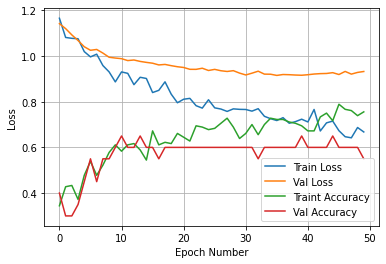

In [14]:
history = np.array(history)
plt.plot(history)
plt.legend(["Train Loss", "Val Loss", "Traint Accuracy", "Val Accuracy"])
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.savefig(src + "_loss_curve.png")
plt.grid()
plt.show()

In [15]:
def predict(model, test_image_name, device):
    """
    Function to predict the class of a single test image
    Parameters
        :param model: Model to test
        :param test_image_name: Test image

    """

    transform = image_transforms["test"]
    test_image = torch.tensor(np.asarray(test_image_name)[::-1,...].copy())
    test_image = transforms.ToPILImage()(test_image)
    plt.imshow(test_image)

    test_image_tensor = test_image_name.unsqueeze(0).to(device)

    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor).to(device)
        ps = torch.exp(out).to(device)
        topk, topclass = ps.topk(3, dim=1)
        for i in range(3):
            print(
                "Predcition",
                i + 1,
                ":",
                idx_to_class[topclass.cpu().numpy()[0][i]],
                ", Score: ",
                round(topk.cpu().numpy()[0][i], 2),
            )

Shoud be Paper

Predcition 1 : Paper , Score:  0.84
Predcition 2 : Scissors , Score:  0.13
Predcition 3 : Rock , Score:  0.03


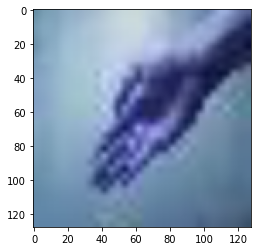

In [16]:
print("Shoud be %s\n" % idx_to_class[0])
predict(
    trained_model.to(device),
    data["valid"][[np.where([x[1] == 0 for x in data["valid"]])[0]][0][1]][0],
    device,
)

Shoud be Rock

Predcition 1 : Rock , Score:  0.78
Predcition 2 : Paper , Score:  0.12
Predcition 3 : Scissors , Score:  0.1


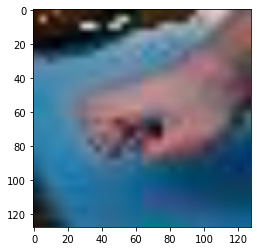

In [17]:
print("Shoud be %s\n" % idx_to_class[1])
predict(
    trained_model,
    data["valid"][[np.where([x[1] == 1 for x in data["valid"]])[0]][0][1]][0],
    device,
)

Shoud be Scissors

Predcition 1 : Scissors , Score:  0.75
Predcition 2 : Paper , Score:  0.13
Predcition 3 : Rock , Score:  0.12


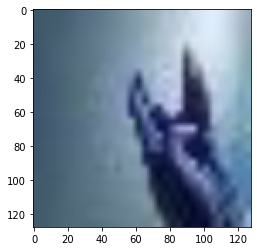

In [18]:
print("Shoud be %s\n" % idx_to_class[2])
predict(
    trained_model,
    data["valid"][[np.where([x[1] == 2 for x in data["valid"]])[0]][0][0]][0],
    device,
)

Мы только что увидели, как использовать предварительно обученную модель, обученную для 1000 классов ImageNet.

Она очень эффективно классифицирует изображения, принадлежащие к 3 различным классам, которые нас интересуют.

Также мы убедидлись в эффективности такого подхода для обучении классификации на небольшом наборе данных.

## One-Shot learning

[Ищем знакомые лица](https://habr.com/ru/post/317798/)

Глубокие сверточные нейронные сети стали самыми современными методами для задач классификации изображений. Однако одно из самых больших ограничений - они требуют большого количества размеченных данных.

Во многих приложениях иногда невозможно собрать такой объем данных и `One Shot Learning` направлен на решение этой проблемы.

Предполагается, что при классификации по методу `One Shot Learning` нам требуется только один обучающий пример для каждого класса. Отсюда и название One Shot. Давайте попробуем разобраться на реальном практическом примере.

Предположим, мы хотим создать систему распознавания лиц для небольшой организации, в которой всего 10 сотрудников (небольшое количество упрощает задачу).

Используя традиционный подход к классификации, мы можем придумать систему, которая выглядит следующим образом:

<img src ="http://edunet.kea.su/repo/src/L11_Transfer_learning/img/OShL1.jpeg" width="700">

Проблемы:

а) Чтобы обучить такую ​​систему, нам сначала потребуется много разных изображений каждого из 10 человек в организации, что может оказаться невозможным. (Представьте, что вы делаете это для организации с тысячами сотрудников).

б) Что делать, если новый человек присоединяется к организации или покидает ее? Вам нужно снова взять на себя боль сбора данных и заново обучить всю модель.

Это практически невозможно, особенно для крупных организаций, где набор и увольнение происходит почти каждую неделю.

Теперь давайте разберемся, как подойти к этой проблеме, используя классификацию по `One Shot Learning`, которая помогает решить обе указанные выше проблемы:

Вместо того, чтобы напрямую классифицировать входное (тестовое) изображение каждого из 10 человек в организации, эта сеть вместо этого принимает дополнительное эталонное изображение человека в качестве входных данных и будет производить оценку сходства, обозначающую шансы того, что два входных изображения принадлежат одному и тому же человеку.

Обратите внимание, что эта сеть не учится классифицировать изображение напрямую по какому-либо из выходных классов. Скорее, он изучает функцию подобия, которая принимает два изображения в качестве входных данных и выражает, насколько они похожи.

Как это решает две проблемы, о которых мы говорили выше?
- Для обучения этой сети нам не требуется слишком много экземпляров класса, а для построения хорошей модели достаточно лишь нескольких экземпляров.
- Но самое большое преимущество в простоте ее обучения в случае появления нового сотрудника.

Теперь, чтобы сеть могла обнаружить его лицо, нам требуется только одно изображение его лица, которое будет сохранено в базе данных. Используя его в качестве эталонного изображения, сеть будет вычислять сходство для любого нового экземпляра,  представленного ей.

Таким образом, мы говорим, что сеть предсказывает счет за `One Shot` (один выстрел).

Код, который мы будем использовать, является реализацией методологии, описанной в этой [исследовательской статье](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf) Грегори Коха и др.

Архитектура модели соответствует описанию в статье. Но прежде чем углубляться в детали, давайте разберемся с архитектурой на высоком уровне.



<img src ="http://edunet.kea.su/repo/src/L11_Transfer_learning/img/OShL6.png" width="700">

Две показанные выше сверточные нейронные сети не являются разными сетями, а представляют собой две копии одной и той же сети, отсюда и название Siamese Networks.

В основном они имеют одинаковые параметры.

Два входных изображения (x1 и x2) проходят через ConvNet, чтобы сгенерировать вектор признаков фиксированной длины для каждого (h (x1) и h (x2)).

Предполагая, что модель нейронной сети обучена правильно, мы можем сделать следующую гипотезу: если два входных изображения принадлежат одному и тому же персонажу, то их векторы признаков также должны быть похожими, а если два входных изображения принадлежат разным символам, то их векторы признаков также будут разными.

Таким образом, поэлементная абсолютная разница между двумя векторами признаков должна сильно отличаться в обоих вышеупомянутых случаях. И, следовательно, оценка сходства, генерируемая выходным сигмовидным слоем, также должна быть разной в этих двух случаях.

Это центральная идея сиамских сетей.

<img src ="http://edunet.kea.su/repo/src/L11_Transfer_learning/img/OShL5.jpeg" width="600">

### Triplet Loss

Для распознавания лиц, мы будем использовать `Triplet loss`, то есть подавать три изображения вместо двух.

Триплет состоит из анкора `anchor`, положительного и отрицательного образцов и в основном применяется для распознавания лиц.

<img src ="http://edunet.kea.su/repo/src/L11_Transfer_learning/img/OShL10.png" width="600">

В `Triplet loss` расстояние между анкором и положительной выборки минимизировано, а расстояние между анкором и отрицательной выборки максимально.

<img src ="http://edunet.kea.su/repo/src/L11_Transfer_learning/img/OShL8.png" width="600">

<img src ="http://edunet.kea.su/repo/src/L11_Transfer_learning/img/OShL9.png" width="600">

### Но можно также использовать и `Contrastive Loss`

о ней подробнее в статье [Dimensionality Reduction by Learning an Invariant Mapping](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf)

### Пример реализации сиамской сети
---
на примере датасета [Georgia Tech face database](http://www.anefian.com/research/face_reco.htm)

In [1]:
import os, glob, random
import shutil
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as img_transf
from torchvision import datasets as ds
from PIL import Image
from torch.autograd import Variable
import torchvision
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

#Фиксируем random_seed
import torch
import random
import numpy as np
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

#Выставлям device для расчетов
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Загрузка данных

In [2]:
!rm -r data
!rm -r GTdb_crop.zip
!rm -r GTdb_crop
!wget http://www.anefian.com/research/GTdb_crop.zip
!unzip GTdb_crop.zip -d /content/GTdb_crop
clear_output()

In [3]:
os.mkdir("/content/data")
for i in range(1, 51):
    pattern = "s" + str(i).zfill(2)
    path = "/content/data/" + str(pattern)
    f = sorted(
        glob.glob(os.path.join("/content/GTdb_crop/cropped_faces/", pattern + "*"))
    )
    os.mkdir(path)
    [shutil.copy(i, path) for i in f]

In [4]:
src = "/content/data/"
d = os.listdir("/content/data")
for i in range(3):
    r = random.choice(d)
    shutil.copytree(src + r, "/content/data/testing/" + r)
    d.remove(r)
else:
    for i in sorted(d):
        shutil.copytree(src + i, "/content/data/training/" + i)

In [5]:
class SiaDataset(Dataset):
    def __init__(self, imageDir, image_transforms=None):
        self.imageDir = imageDir
        self.classes = self.imageDir.classes
        self.imgs = self.imageDir.imgs
        self.transform = image_transforms

    def __getitem__(self, index):
        self.target = np.random.randint(
            0, 2
        )  # Выберем либо положительную пару (0), либо отрицательную (1)

        img1, label1 = self.imgs[index]  # Выберем первое изображение

        new_imgs = list(
            set(self.imgs) - set(self.imgs[index])
        )  # Создадим новый индекс, что бы не повторять уже выбранное изображение
        length = len(new_imgs)

        if self.target == 1:
            # Найдем отрицательный пример
            label2 = label1
            while label2 == label1:
                choice = np.random.choice(length)
                img2, label2 = new_imgs[choice]
        else:
            # Найдем положительный пример
            label2 = label1 + 1
            while label2 != label1:
                choice = np.random.choice(length)
                img2, label2 = new_imgs[choice]

        img1 = Image.open(img1).convert("RGB")
        img2 = Image.open(img2).convert("RGB")
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return (img1, img2, self.target)

    def __len__(self):
        return len(self.imgs)

### Создание модели

In [6]:
class Siamese(nn.Module):
    def __init__(self):
        super(Siamese, self).__init__()

        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(64 * 11 * 11, 4096), nn.Sigmoid(), nn.Linear(4096, 128)
        )

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(-1, 64 * 11 * 11)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

### Contrastive Loss

In [7]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        pos = (1 - label) * torch.pow(euclidean_distance, 2)
        neg = (label) * torch.pow(
            torch.clamp(self.margin - euclidean_distance, min=0.0), 2
        )
        loss_contrastive = torch.mean(pos + neg)
        return loss_contrastive

In [8]:
# Вспомогательная функция
def show(img, text=None):
    img = img.numpy()
    plt.axis("off")
    plt.text(75, 120, text, fontweight="bold")
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

In [9]:
# Применим аугментации для train
im_trans_train = img_transf.Compose(
    [
        img_transf.Resize((105, 105)),
        img_transf.RandomPerspective(),
        img_transf.RandomRotation((-15, 15)),
        img_transf.RandomHorizontalFlip(),
        img_transf.GaussianBlur(3, sigma=(0.1, 2.0)),
        img_transf.ToTensor(),
    ]
)

# Применим аугментации для test
im_trans_test = img_transf.Compose(
    [img_transf.Resize((105, 105)), img_transf.ToTensor()]
)

folder_dataset = ds.ImageFolder("/content/data/training")
sia_dataset = SiaDataset(
    imageDir=folder_dataset,
    image_transforms=im_trans_train,
)

# Создадим случайную инициализацию seed, что бы каждый раз действительно выбирать новые изображения
def worker_init_fn(worker_id):
    np.random.seed(np.random.get_state()[1][0] + worker_id)


train_dataloader = DataLoader(
    sia_dataset,
    shuffle=True,
    num_workers=2,
    worker_init_fn=worker_init_fn,
    batch_size=64,
)

folder_dataset = ds.ImageFolder("/content/data/testing")

siatest_dataset = SiaDataset(
    imageDir=folder_dataset,
    image_transforms=im_trans_test,
)


test_dataloader = DataLoader(
    siatest_dataset,
    num_workers=2,
    batch_size=1,
    shuffle=True,
    worker_init_fn=worker_init_fn,
)

### Обучение

In [10]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

net = Siamese().to(device)
loss_fun = ContrastiveLoss(margin=1.5)
optims = optim.Adam(net.parameters(), lr=3e-4)
scheduler = ReduceLROnPlateau(optims, "min", verbose=True, factor=0.5, patience=3)

In [11]:
net

Siamese(
  (cnn1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=7744, out_features=4096, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=4096, out_features=128, bias=True)
  )
)

In [12]:
!mkdir saved_weight

In [13]:
def train(n_epoch, net, optims, scheduler, save=True, path="saved_weight"):
    counter = []
    l = []

    iter_num = 0

    for epoch in range(0, n_epoch):
        
        for i, data in enumerate(train_dataloader, 0):
            img0, img1, label = data
            img0, img1, label = img0.to(device), img1.to(device), label.to(device)
            optims.zero_grad()
            out = net(img0, img1)
            op1, op2 = net(img0, img1)
            loss = loss_fun(op1, op2, label)

            loss.backward()
            optims.step()

            if i % 12 == 0:
                print("Epoch {} with {} loss".format(epoch, loss.item()))
                iter_num += 5
                counter.append(iter_num)
                l.append(loss.item())
                if save:  # будем сохранять все этапы обучения модели
                    torch.save(net.state_dict(), path + "/epoch_%i.pt" % epoch)
                scheduler.step(loss)  # используем подстройку lr при достижении "плато"
    return counter, l

In [ ]:
counter, l = train(30, net, optims, scheduler, save=True, path="saved_weight")

In [15]:
plt.plot(counter, l)
plt.grid()
plt.show()

NameError: ignored

### Проверка

In [ ]:
def plot_images(l, path="saved_weight"):
    distances_pos = []
    distances_neg = []

    net = Siamese().to(device)

    best_epoch = np.argmin(l)
    print("Лучшая эпоха: %i. Loss = %.3f" % (best_epoch, l[best_epoch]))

    # Загрузим лучушю эпоху из сохранения
    net.load_state_dict(torch.load(path + "/epoch_%i.pt" % best_epoch))
    net.eval()

    for i, data in enumerate(test_dataloader, 0):
        img0, img1, label = data
        concatenated = torch.cat((img0, img1))
        output1, output2 = net(Variable(img0).to(device), Variable(img1).to(device))
        distance = F.pairwise_distance(output1, output2)
        if label == 0:
            distances_pos.append(distance.item())
            if i % 50:
                show(
                    torchvision.utils.make_grid(concatenated),
                    "Один и тот же! Missmatch: {:.3f}".format(distance.item()),
                )
        else:
            distances_neg.append(distance.item())
            if i % 50:
                show(
                    torchvision.utils.make_grid(concatenated),
                    "Другой человек! Missmatch: {:.3f}".format(distance.item()),
                )
    return distances_pos, distances_neg


distances_pos, distances_neg = plot_images(l)

Так оценить работу сложно, давайте посмотрим на распределение расстояний по категориям

In [ ]:
import seaborn as sns

distnaces = {"Один и тот же": distances_pos, "Другой человек": distances_neg}

ax = sns.displot(distnaces, kde=True, stat="density")
ax.set(xlabel="Pairwise distance")

## Оптимизация гиперпараметров

Часто, когда мы пишем и обучаем сети (будь то с нуля или с помощью transfer learning) мы вынуждены угадывать гиперпараметры (lr, betas и тд). В случае с learning rate нам есть от чего оттолкнуться (маленький lr для transfer learning), [константа Karpathy (3e-4)](https://twitter.com/karpathy/status/801621764144971776?lang=en) для Adam, но все же, такой подход не кажется оптимальным.

Для оптимизации гиперпараметров существуют готовые решения, которые используют различные методы black-box оптимизации. Разберем одну из наиболее популярных библиотек - [**Optuna**](https://optuna.org/)

In [ ]:
!pip install --quiet optuna

Давайте оптимизируем наш learning rate

In [ ]:
import torch
import optuna

# Определим функицю которую будем оптимизировать
def objective(trial):
    # Создадим границы для "предположений" оптимизатора
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)

    # Будем каждый раз пересоздавать нашу сеть и все ее парамеры
    net = Siamese().to(device)
    loss_fun = ContrastiveLoss(margin=1.5)
    optims = optim.Adam(
        net.parameters(), lr=lr
    )  # Теперь lr предлагает optuna в пределах заданых границ
    scheduler = ReduceLROnPlateau(optims, "min", verbose=True, factor=0.5, patience=3)

    # Для экономии времени возьмем только 3 эпохи
    counter, l = train(3, net, optims, scheduler, save=False)
    return l[-1]


# Создадим "исследование",
study = optuna.create_study(direction="minimize", study_name="Optimal lr")

#
study.optimize(
    objective, n_trials=15
)  # Чем больше итераций - тем выше шансы словить самые оптимальные гиперпараметры

In [ ]:
# Посмотрим на лучшие параметры
study.best_params

Конечно же, можно оптимизировать сразу несколько параметров за раз, а еще в качестве параметров можеть быть сама архитектура сети (например количесвто слоев и каналов). Это можно легко сделать по анологии

Давайте посмотрим на историю оптимизации нашего lr

In [ ]:
optuna.visualization.plot_optimization_history(study)

Что ж, проверим а станет ли реально лучше

In [ ]:
!mkdir 'optimal_weight'

In [ ]:
net = Siamese().to(device)
loss_fun = ContrastiveLoss(margin=1.5)
optims = optim.Adam(
    net.parameters(), lr=study.best_params["lr"]
)  # Возьмем lr, который нам предлагает Optuna
scheduler = ReduceLROnPlateau(optims, "min", verbose=True, factor=0.5, patience=3)

counter, l_optim = train(30, net, optims, scheduler, save=True, path="optimal_weight")

In [ ]:
plt.plot(counter, l, label="no optimization")
plt.plot(counter, l_optim, label="optimal params")
plt.grid()
plt.legend()
plt.show()

In [ ]:
distances_pos, distances_neg = plot_images(l_optim)

In [ ]:
import seaborn as sns

distnaces_optim = {"Один и тот же": distances_pos, "Другой человек": distances_neg}

ax_0 = sns.displot(distnaces, kde=True, stat="density", alpha=0.5)
ax_1 = sns.displot(distnaces_optim, kde=True, stat="density", alpha=0.5)
ax_0.set(xlabel="Pairwise distance")

## Выводы
---

На этом уроке мы затронули проблемы, которые возникают при обучени на реальных данных.

Одна из основных проблем - малые датасеты. Для того, чтобы обучить нейронку на небольшом датасете можно использовать:
- `аугментацию`
- `Tranfer learning`
Однако необходимо помнить, что ни один из этих методов не защитит от ситуации, когда реальные данные будут сильно отличаться от тренировочных.

В случае, когда у нас не только мало данных, но и еще и очень большое (возможно, неизвестное) число классов, можно воспользоваться `One-shot Learning`. В этом случае нейронка обучается не классифицировать изображения, а, наоборот, находить различия между классом и новыми данными. Для этого используются нейронные сети, относящиеся к классу сиамских нейронных сетей.

Так же мы разобрали автоматическую оптимизацию гиперпараметров с помощью Optuna и показали, что это эффективный способ сделать нейросеть лучше малой ценой.

## Литература
---

### Augmentation

[TORCHVISION.TRANSFORMS](https://pytorch.org/vision/stable/transforms.html)

[A survey on Image Data Augmentation for Deep Learning](https://link.springer.com/article/10.1186/s40537-019-0197-0)

[Data augmentation for improving deep learning in image classification problem](https://www.researchgate.net/publication/325920702_Data_augmentation_for_improving_deep_learning_in_image_classification_problem)

[Albumentations](https://github.com/albumentations-team/albumentations)



### Transfer Learning
[How To Do Transfer Learning For Computer Vision | PyTorch Tutorial](https://www.youtube.com/watch?v=6nQlxJvcTr0)

[TRANSFER LEARNING FOR COMPUTER VISION TUTORIAL](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

[Python Pytorch Tutorials # 2 Transfer Learning : Inference with ImageNet Models](https://www.youtube.com/watch?v=Upw4RaERZic)

[PyTorch - The Basics of Transfer Learning with TorchVision and AlexNet](https://www.youtube.com/watch?v=8etkVC93yU4)

### One-shot Learning

[One Shot Learning with Siamese Networks using Keras](https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d)

[One-shot image classification by meta learning](https://medium.com/nerd-for-tech/one-shot-learning-fe1087533585)

[Siamese Neural Networks for One-shot Image Recognition](http://www.cs.toronto.edu/~rsalakhu/papers/oneshot1.pdf)

[One-shot learning (Part 1/2): Definitions and fundamental techniques](https://heartbeat.fritz.ai/one-shot-learning-part-1-2-definitions-and-fundamental-techniques-1df944e5836a)

[One-Shot Learning (Part 2/2): Facial Recognition Using a Siamese Network](https://heartbeat.fritz.ai/one-shot-learning-part-2-2-facial-recognition-using-a-siamese-network-5aee53196255)

[FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/pdf/1503.03832.pdf)

[One shot learning explained using FaceNet](https://medium.com/intro-to-artificial-intelligence/one-shot-learning-explained-using-facenet-dff5ad52bd38)


### Hyperparameter optimization
[Tuning Hyperparameters with Optuna](https://towardsdatascience.com/tuning-hyperparameters-with-optuna-af342facc549)